# Аналитика маркетплейса

В этом задании вам придется оказаться на месте аналитика в бразильском маркетплейсе Olist. Вам необходимо исследовать данные и на их основании сделать выводы, которые помогут бизнесу расцветать!

## Задание 0

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import zipfile
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go
import plotly.express as px
from datetime import datetime, date
from plotly.subplots import make_subplots

In [ ]:
!wget -O data.zip https://github.com/Palladain/Deep_Python/blob/main/Homeworks/Homework_1/archive.zip?raw=true

In [3]:
with zipfile.ZipFile('data.zip', 'r') as zip_ref:
    zip_ref.extractall('/content')

In [4]:
customers_df = pd.read_csv('olist_customers_dataset.csv')
geolocation_df = pd.read_csv('olist_geolocation_dataset.csv')
items_df = pd.read_csv('olist_order_items_dataset.csv')
payments_df = pd.read_csv('olist_order_payments_dataset.csv')
reviews_df = pd.read_csv('olist_order_reviews_dataset.csv')
orders_df = pd.read_csv('olist_orders_dataset.csv')
products_df = pd.read_csv('olist_products_dataset.csv')
sellers_df = pd.read_csv('olist_sellers_dataset.csv')
translated_products = pd.read_csv('product_category_name_translation.csv')

Посмотрим, как выглядит таблицы

In [ ]:
customers_df.head()

In [ ]:
geolocation_df.head()

In [ ]:
items_df.head()

In [ ]:
payments_df.head()

In [ ]:
reviews_df.head()

In [ ]:
orders_df.head()

In [ ]:
products_df.head()

In [ ]:
sellers_df.head()

In [ ]:
translated_products.head()

Объединим

In [14]:
df = pd.merge(orders_df, items_df, on = 'order_id')
df = pd.merge(df, customers_df, on = 'customer_id')
df = pd.merge(df, sellers_df, on = 'seller_id')
df = pd.merge(df, products_df, on = 'product_id')
df = pd.merge(df, payments_df, on = 'order_id')
df = pd.merge(df, reviews_df, on = 'order_id')
df = pd.merge(df, translated_products, on = 'product_category_name')
df.rename(columns = {'seller_zip_code_prefix': 'geolocation_zip_code_prefix'}, inplace = True)

In [ ]:
df.head(1).T

In [ ]:
df.info()

Создадим новые столбцы, поменяем типы данных

In [16]:
df['review_creation_date'] = pd.to_datetime(df['review_creation_date'])
df['review_answer_timestamp'] = pd.to_datetime(df['review_answer_timestamp'])
df['order_approved_at'] = pd.to_datetime(df['order_approved_at'])
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
df['order_delivered_customer_date'] = pd.to_datetime(df['order_delivered_customer_date'])
df['day'] = df['order_purchase_timestamp'].dt.day
df['month'] = df['order_purchase_timestamp'].dt.month
df['hour'] = df['order_purchase_timestamp'].dt.hour
df['date'] = df['order_purchase_timestamp'].dt.date
df['wkdayname'] = df['order_purchase_timestamp'].dt.day_name()

In [ ]:
df.isnull().sum()

Заменим пропуски в столбцах

In [18]:
df[['review_comment_title', 'review_comment_message']] = df[['review_comment_title', 'review_comment_message']].fillna('nocomment')

Можно удалить одну запись без характеристик продукта, ничего не потеряем

In [19]:
df = df.dropna(subset=['product_width_cm', 'product_height_cm', 'product_weight_g', 'product_length_cm'])

## Задание 1

Определите:

* Число товаров
* Среднюю стоимость товара

в разрезе категорий (все категории должны быть на английском языке)

Определим число всех (= неуникальных) товаров по категориям

In [20]:
df.groupby('product_category_name_english').agg({
    'product_id': 'count'}).reset_index().sort_values(by = 'product_id', ascending = False)

,product_category_name_english,product_id
7,bed_bath_table,11847
43,health_beauty,9944
65,sports_leisure,8942
39,furniture_decor,8743
15,computers_accessories,8105
...,...,...
3,arts_and_craftmanship,24
52,la_cuisine,15
11,cds_dvds_musicals,14
29,fashion_childrens_clothes,8


Определим среднюю стоимость товара по категориям

In [21]:
df.groupby('product_category_name_english').agg(
    {'price': 'mean'}).reset_index().sort_values(by = 'price', ascending = False)

,product_category_name_english,price
14,computers,1078.555806
64,small_appliances_home_oven_and_coffee,627.509103
45,home_appliances_2,459.567388
0,agro_industry_and_commerce,332.706151
56,musical_instruments,290.755042
...,...,...
12,christmas_supplies,54.838649
11,cds_dvds_musicals,52.142857
23,diapers_and_hygiene,40.194615
35,flowers,32.265806


## Задание 2

Определите для каждого продавца основную категорию их продаж.

Отобразите категории по числу продавцов, для которых данная категория основная, а также создайте график, по которому можно выбрать отдельно штат и посмотреть такое же распределение



Определим для каждого продавца основную категорию продаж

In [53]:
df_presel = df.groupby(['seller_id', 'product_category_name_english', 'seller_state']).agg(
    {'product_id': 'count'}).reset_index().sort_values(
        by = 'product_id', ascending = False).drop_duplicates(['seller_id'])

df_presel.head()

,seller_id,product_category_name_english,seller_state,product_id
775,1f50f920176fa81dab994f9023523100,garden_tools,SP,1955
2521,6560211a19b47992c3666cc44a7e94c0,watches_gifts,SP,1683
1801,4a3ca9315b744ce9f8e9374361493884,bed_bath_table,SP,1683
5348,da8622b14eb17ae2831f4ac5b9dab84a,bed_bath_table,SP,1380
387,1025f0e2d44d7041d6cf58b6550e0bfa,furniture_decor,SP,1328


Для каждой категории определяем кол-во продавцов, для которых данная категория основная

In [23]:
df_presel_grouped = df.groupby(['seller_id', 'product_category_name_english']).agg(
    {'product_id': 'count'}).reset_index().sort_values(
        by = 'product_id', ascending = False).drop_duplicates(['seller_id']).groupby(['product_category_name_english']).agg({
            'seller_id': 'count'}).reset_index().sort_values(by = 'seller_id', ascending = False)

df_presel_grouped

,product_category_name_english,seller_id
41,health_beauty,308
61,sports_leisure,286
46,housewares,258
37,furniture_decor,227
5,auto,212
...,...,...
9,books_imported,2
39,furniture_mattress_and_upholstery,1
49,la_cuisine,1
63,tablets_printing_image,1


Визуализируем (это можно сделать и в Plotly, но решил разнообразить и сделал в Seaborn, через один будет в Plotly)

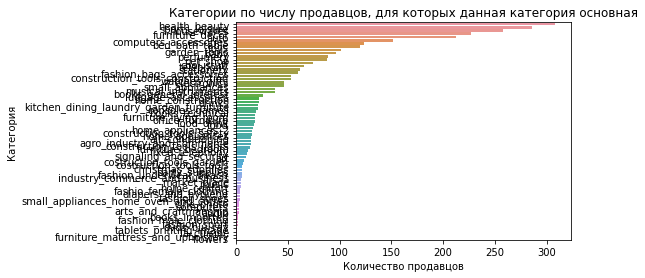

In [24]:
sns.countplot(y = df_presel['product_category_name_english'], order = df_presel['product_category_name_english'].value_counts().index)
plt.title('Категории по числу продавцов, для которых данная категория основная')
plt.xlabel('Количество продавцов')
plt.ylabel('Категория')
plt.rcParams['figure.figsize'] = 24, 12
plt.rcParams['font.size'] = 12
plt.show()

Такое же распределение, но с возможностью выбрать штат

In [25]:
fig = px.histogram(df_presel, y = 'product_category_name_english', color = 'seller_state')
fig.update_layout(
    title = 'Категории по числу продавцов, для которых данная категория основная',
    xaxis_title = 'Количество продавцов', yaxis_title = 'Категория',
    title_x = 0.5,
    margin = dict(l = 0, r = 0, t = 30, b = 0))

fig.show()

## Задание 3*

Имея полученные данные по товарам, чекам и категориям, а также сделав дополнительные расчеты (если необходимо), предположите:

1. Продавцов каких категорий необходимо привлекать в маркетплейс?

2. Какие категории в каких штатах необходимо развивать?

3. Развитие каких категорий не принесут большого эффекта и почему?

4. Какие рекомендации можно дать для продавцов, чтобы их товар лучше продавался?

1. Примем за факт, что спрос на все категории одинаков/равномерен (или он хотя бы есть). Тогда посчитаем нижную квартиль кол-ва продавцов по категориям, для которых эта категория основная. Все, что меньше ее - продавцов следующих категорий необходимо привлекать в маркетплейс:

In [26]:
df_selcat = df.groupby(['product_category_name_english']).agg({'seller_id': 'count'}).reset_index().sort_values(by = 'seller_id').head(10)
sel_qunt = np.quantile(df_selcat['seller_id'], 0.25)
df_selcat[df_selcat['seller_id'] < sel_qunt]

,product_category_name_english,seller_id
61,security_and_services,2
29,fashion_childrens_clothes,8
11,cds_dvds_musicals,14


2. Поступим аналогично. Следующие категории в определенных штатах необходимо развивать:

In [27]:
df_stcat = df.groupby(['seller_state','product_category_name_english']).agg({'order_id': 'count'}).reset_index()
st_qunt = np.quantile(df_stcat['order_id'], 0.25)
df_stcat[df_stcat['order_id'] < st_qunt]

,seller_state,product_category_name_english,order_id
0,AC,books_technical,1
1,AM,telephony,3
5,BA,cool_stuff,1
6,BA,drinks,1
7,BA,electronics,3
...,...,...,...
404,SC,home_confort,3
412,SC,music,2
427,SE,industry_commerce_and_business,1
480,SP,la_cuisine,2


3. Будем считать, что те категории, которые попадают в нижную квартиль сразу по двум показателям, развивать не стоит. Это следующие показатели: кол-во заказов (если категория не приносит большой прибыли, но тем не менее она повышает retention, например, то развивать ее все равно стоит) и сумма, получаемая маркетплейсом. Если мы не получаем никакой прибыли и это не повышает вовлеченность клиента в наш маркетплейс, то развивать категорию не имеет смысла

In [28]:
df_perscats = df.groupby('product_category_name_english').agg({'payment_value': 'sum', 'order_id': 'count'}).reset_index()
ord_qunt = np.quantile(df_perscats['order_id'], 0.25)
val_qunt = np.quantile(df_perscats['payment_value'], 0.25)
df_perscats[(df_perscats['order_id'] < ord_qunt) & (df_perscats['payment_value'] < val_qunt)]

,product_category_name_english,payment_value,order_id
3,arts_and_craftmanship,2326.17,24
9,books_imported,6701.89,62
11,cds_dvds_musicals,1199.43,14
13,cine_photo,9553.61,74
23,diapers_and_hygiene,4221.25,39
25,dvds_blu_ray,7900.75,70
27,fashio_female_clothing,5220.07,50
29,fashion_childrens_clothes,785.67,8
32,fashion_sport,3685.01,31
35,flowers,1922.77,31


4. Выше мы определили, в каких областях стоит развиваться и почему. Тем же советам должны следовать продавцы. В табличке df_stcat можно узнать, какие категории и в каких штатах стоит развивать. В то же время, если категория присутствует в табличке df_perscats, то продолжаться заниматься ею будет не лучшим вариантом

## Задание 4

Определите средний чек покупки (добавьте разбивку на стоимость самого заказ и стоимость доставки) и среднее число товаров в заказе

In [29]:
print(f"Среднее число товаров в заказе: {np.mean(df.groupby('order_id').agg({'order_item_id': 'count'}).reset_index()['order_item_id'])}")
print(f"Средний чек покупки: {np.mean(df.groupby('order_id').agg({'payment_value': 'sum'}).reset_index()['payment_value'])}")
print(f"Средняя стоимость доставки: {np.mean(df.groupby('order_id').agg({'freight_value': 'sum'}).reset_index()['freight_value'])}")
print(f"Средний чек покупки без учета доставки: {np.mean(df.groupby('order_id').agg({'payment_value': 'sum'}).reset_index()['payment_value'] - df.groupby('order_id').agg({'freight_value': 'sum'}).reset_index()['freight_value'])}")

Среднее число товаров в заказе: 1.197824172408434
Средний чек покупки: 206.47123763145626
Средняя стоимость доставки: 24.024543231622033
Средний чек покупки без учета доставки: 182.44669439983423


## Задание 5

Определите среднее число покупок на пользователя (обратите внимание на идентификаторы)

In [30]:
print(f"Среднее число покупок на пользователя: {np.mean(df.groupby('customer_unique_id').agg({'order_id': 'count'}).reset_index()['order_id'])}")

Среднее число покупок на пользователя: 1.2378392847582846


## Задание 6

Отобразите среднюю сумму оплаты по типу оплаты

In [31]:
df.groupby('payment_type').agg({'payment_value': 'mean'}).reset_index()

,payment_type,payment_value
0,boleto,176.950041
1,credit_card,179.400532
2,debit_card,150.403080
3,voucher,64.292139


## Задание 7

Обратите внимание на число платежей (payment_installments). Выясните, какая сумма оплаты указана: за целую покупку или только за ее часть?

Также покажите средний чек в зависимости от числа оплаты. Есть ли какая-то связь между ними?

Посмотрим на пользоввателя, у которого число платежей больше одного. 

In [32]:
df[df['customer_id'] == '0b86a8c0b1664d2b4e10efbd1321f889']

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,...,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,product_category_name_english,day,month,hour,date,wkdayname
15,4609e3dffa747068028fe0a5962b41f2,0b86a8c0b1664d2b4e10efbd1321f889,delivered,2017-10-19 19:05:28,2017-10-20 09:56:21,2017-10-23 15:32:36,2017-11-06 21:09:01,2017-11-17 00:00:00,1,1e618d311a1b7f88a9d96ec50aa85582,...,nocomment,Comprei um cesto de roupas e 4 tapetes. Porém ...,2017-11-08,2017-11-08 10:32:17,housewares,19,10,19,2017-10-19,Thursday
83340,4609e3dffa747068028fe0a5962b41f2,0b86a8c0b1664d2b4e10efbd1321f889,delivered,2017-10-19 19:05:28,2017-10-20 09:56:21,2017-10-23 15:32:36,2017-11-06 21:09:01,2017-11-17 00:00:00,2,4dda033e39cdc37ce2932b7ba6e8a0f7,...,nocomment,Comprei um cesto de roupas e 4 tapetes. Porém ...,2017-11-08,2017-11-08 10:32:17,bed_bath_table,19,10,19,2017-10-19,Thursday


Видим, что число записей никак не связано с числом платежей (две записи связаны с двумя товарами). Payment_value тоже остается одним и тем же, поэтому сумма оплаты указана за целую покупку

Посмотрим на средний чек в зависимости от числа оплаты

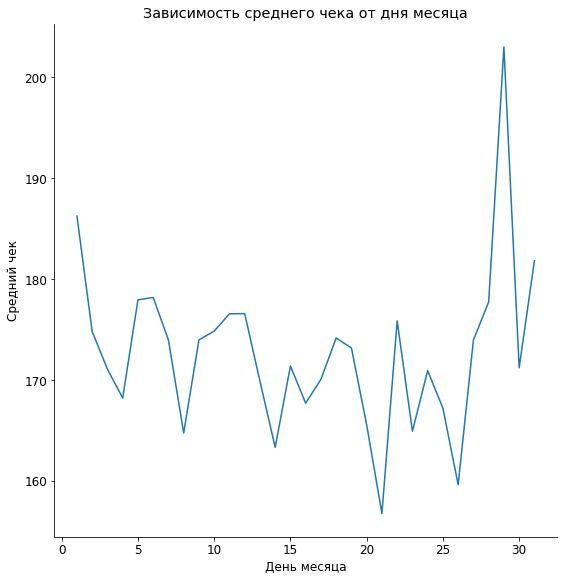

In [33]:
df_day = df.groupby(['day']).agg({'payment_value': 'mean'})

sns.relplot(data = df_day, kind = 'line', height = 8, legend = False)
plt.title('Зависимость среднего чека от дня месяца')
plt.xlabel('День месяца')
plt.ylabel('Средний чек')
plt.rcParams['font.size'] = 12
plt.show()

Видим, что в первых числах покупают достаточно много. Под конец месяца тоже видны рывки вверх, возможно, дело в платежных периодах Бразилии

## Задание 8

Визуализируйте зависимость между ценой заказа и ценой доставки по штатам покупки. Есть ли какая-нибудь зависимость и как вы можете ее обосновать?

In [34]:
fig = px.scatter(df, x = 'freight_value', y = 'payment_value', color = 'customer_state')
fig.update_layout(
    title = 'Зависимость между ценой заказа и ценой доставки по штатам',
    xaxis_title = 'Стоимость доставки', yaxis_title = 'Стоимость заказа',
    title_x = 0.5,
    margin = dict(l = 0, r = 0, t = 30, b = 0))
fig.update_yaxes(range=[0, 4500])
fig.update_xaxes(range=[0, 400])
fig.show()

Есть умеренная линейная взаимосвязь между стоимостью доставки и стоимостью заказа. Если говорить о штате, то кажется, там, где мало заказов, там и доставка дороже. Возможно, это отдаленный штат. Также мы выше видели, что большинство продавцов сконцентрировано в нескольких штатах; в "неосновных", логично, доставка будет дороже

## Задание 9

Выведите график по числу покупок (в разбивке по статусам) и временем покупки (аггрегируйте покупки до дня)

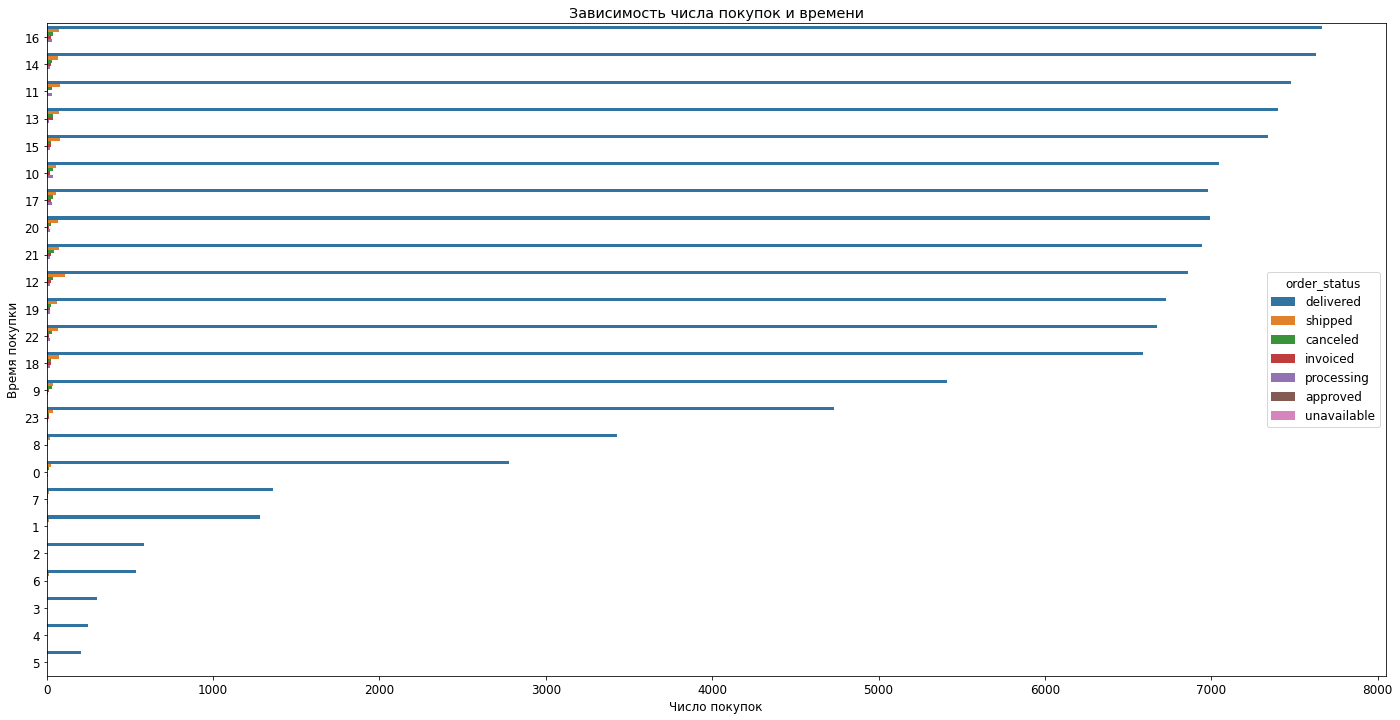

In [35]:
sns.countplot(y = df['hour'], hue = df['order_status'], order = df['hour'].value_counts().index)
plt.title('Зависимость числа покупок и времени')
plt.xlabel('Число покупок')
plt.ylabel('Время покупки')
plt.rcParams['figure.figsize'] = 24, 12
plt.rcParams['font.size'] = 12
plt.show()

## Задание 10*

Используя полученные данные, а также сделав дополнительные вычисления (если необходимо), предположите:

1. Есть ли сезонность в покупках на маркетплейсе?

2. Есть ли какие-то необъяснимые падение/рост продаж? С чем это может быть связано?

1. Мы не можем говорить о квартальной сезонности, потому что у нас слишком мало данных. Магазин отработал только один полный год. Да, на графике, например, ниже мы видим, что в 17 году у нас наблюдается скорее линейный рост. Можем ли мы говорить, что есть сезонность, если мы можем это объяснить просто ростом фирмы? Кажется, что нет

Если говорить о других формах сезонности, то выше мы видели, что рост покупок наблюдается в начале и конце месяца. Возможно, это связано с зарплатными периодами в Бразилии. Также мы выявили часы, в которые больше всего заказов (не совсем сезонность, конечно, но связь тут есть!) 

Также интересно посмотреть на день недели. Сделаем это в следующей ячейке

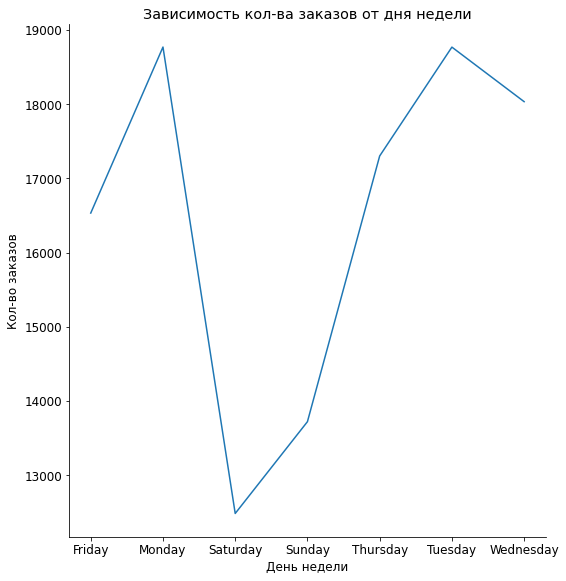

In [36]:
df_dayweek = df.groupby(['wkdayname']).agg({'order_id': 'count'})

sns.relplot(data = df_dayweek, kind = 'line', height = 8, legend = False)
plt.title('Зависимость кол-ва заказов от дня недели')
plt.xlabel('День недели')
plt.ylabel('Кол-во заказов')
plt.rcParams['font.size'] = 12
plt.show()

Да, тут тоже связь есть. На выходных толком ничего не покупают, в отличие от рабочих дней

2. Да, есть. На следующем графике мы видим как минимум один резкий рост. Возможно, дело в какой-то знаковой рекламной интеграции в СМИ/ТВ/интернете/где-то еще; возможно, дело в каких-нибудь грандиозных акциях. Также мы проседание в середине 2018 года. Дело может быть в каком-нибудь скандале, плохой работе платформы, бойкоте некоторых крупных продавцов

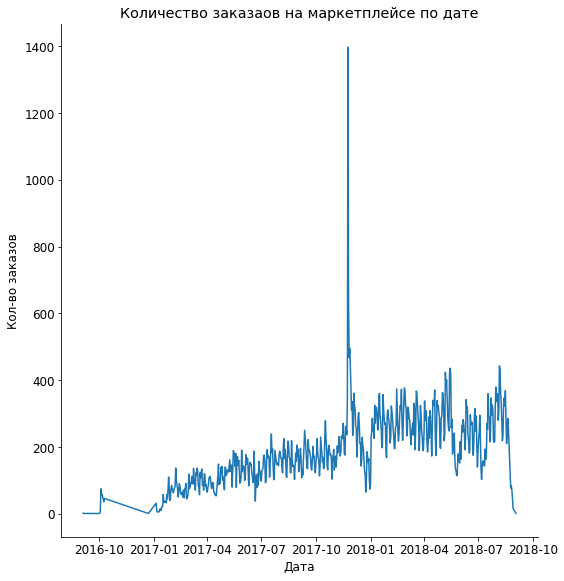

In [37]:
df_dayweek = df.groupby(['date']).agg({'order_id': 'count'})

sns.relplot(data = df_dayweek, kind = 'line', height = 8, legend = False)
plt.title('Количество заказаов на маркетплейсе по дате')
plt.xlabel('Дата')
plt.ylabel('Кол-во заказов')
plt.rcParams['font.size'] = 12
plt.show()

## Задание 11

Посчитайте CSAT (customer satisfaction - средняя оценка ревью) и отобразите средний CSAT по дням



Средний CSAT

In [38]:
print(f"Средний CSAT: {np.mean(df['review_score'])}")

Средний CSAT: 4.034400733513252


CSAT по дням

In [39]:
df_csat = df.groupby('date').agg({'review_score': 'mean'})
df_csat

,review_score
date,
2016-09-04,1.000000
2016-09-05,1.000000
2016-10-02,1.000000
2016-10-03,3.000000
2016-10-04,3.853333
...,...
2018-08-26,4.297619
2018-08-27,4.357143
2018-08-28,4.446809


Визуализируем CSAT по дням

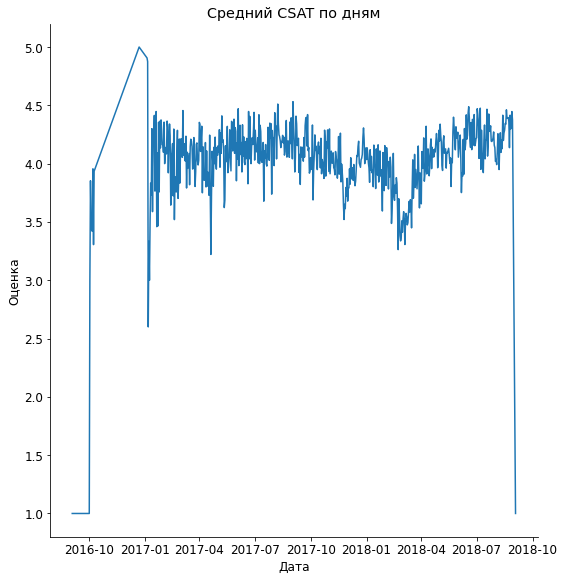

In [40]:
sns.relplot(data = df_csat, kind = 'line', height = 8, legend = False)
plt.title('Средний CSAT по дням')
plt.xlabel('Дата')
plt.ylabel('Оценка')
plt.rcParams['font.size'] = 12
plt.show()

## Задание 12

Найдите топ-5 лучших и топ-5 худших продавцов по средней оценке и посчитайте их число продаж

Найдем пять лучших

In [41]:
df.groupby('seller_id').agg({'review_score': 'mean', 'order_id': 'count'}).reset_index().sort_values(by = 'review_score').tail(5)

,seller_id,review_score,order_id
128,0ad80de75c811326389cfb1daba7d45e,5.0,5
1135,5e106d93b717c2682b9383da480364a1,5.0,1
690,3bfba5a77604f6dfae7e6dd7aaf65821,5.0,4
2040,acf974e4d5950ad143a247471b831eb9,5.0,7
1870,9d213f303afae4983637247556438ede,5.0,3


Найдем пять худших

In [42]:
df.groupby('seller_id').agg({'review_score': 'mean', 'order_id': 'count'}).reset_index().sort_values(by = 'review_score').head(5)

,seller_id,review_score,order_id
2413,cb4a705d00e100b9732d0ca34817d441,1.0,2
2725,e6ffc9ac6a7adc9d16a1cfc2286dd546,1.0,1
290,19484c79cef6c062cb177aa4ef2fcc3c,1.0,1
242,154bdf805377afea75a3bd158e9eab10,1.0,1
2456,cecd97bc34ed8330bd4cd15713eda670,1.0,1


## Задание 13

Посмотрите, как быстро отвечают пользователи (сделайте аггреграцию по дням) и влияет ли это на оценку?

Создаем признак

In [43]:
df['answer_days'] = (df['review_answer_timestamp'] - df['review_creation_date']).astype('timedelta64[D]')

Посмотрим на то, как часто люди отвечают в тот или иной промежуток

In [44]:
df.groupby('answer_days').agg({'order_id': 'count'}).reset_index().sort_values(by = 'order_id', ascending = False)

,answer_days,order_id
1,1.0,36119
0,0.0,28066
2,2.0,18555
3,3.0,16464
4,4.0,5350
...,...,...
157,197.0,1
156,194.0,1
155,192.0,1
154,191.0,1


Посмотрим на корреляцию

In [45]:
df.groupby('answer_days').agg({'review_score': 'mean'}).reset_index().corr()

,answer_days,review_score
answer_days,1.000000,0.140748
review_score,0.140748,1.000000


## Задание 14

Отобразите распределение оценок для заказов, которые были доставлены вовремя и которые пришли с опозданием. Насколько влияет факт опоздания на оценку?

Создадим признак, отвечающий за факт опоздания

In [46]:
df['is_late'] = np.where(df['order_estimated_delivery_date'] < df['order_delivered_customer_date'], 1, 0)

In [47]:
df_islate = df.groupby('is_late').agg({'review_score': 'mean'}).reset_index()
df_islate

,is_late,review_score
0,0,4.155483
1,1,2.549283


Визуализируем

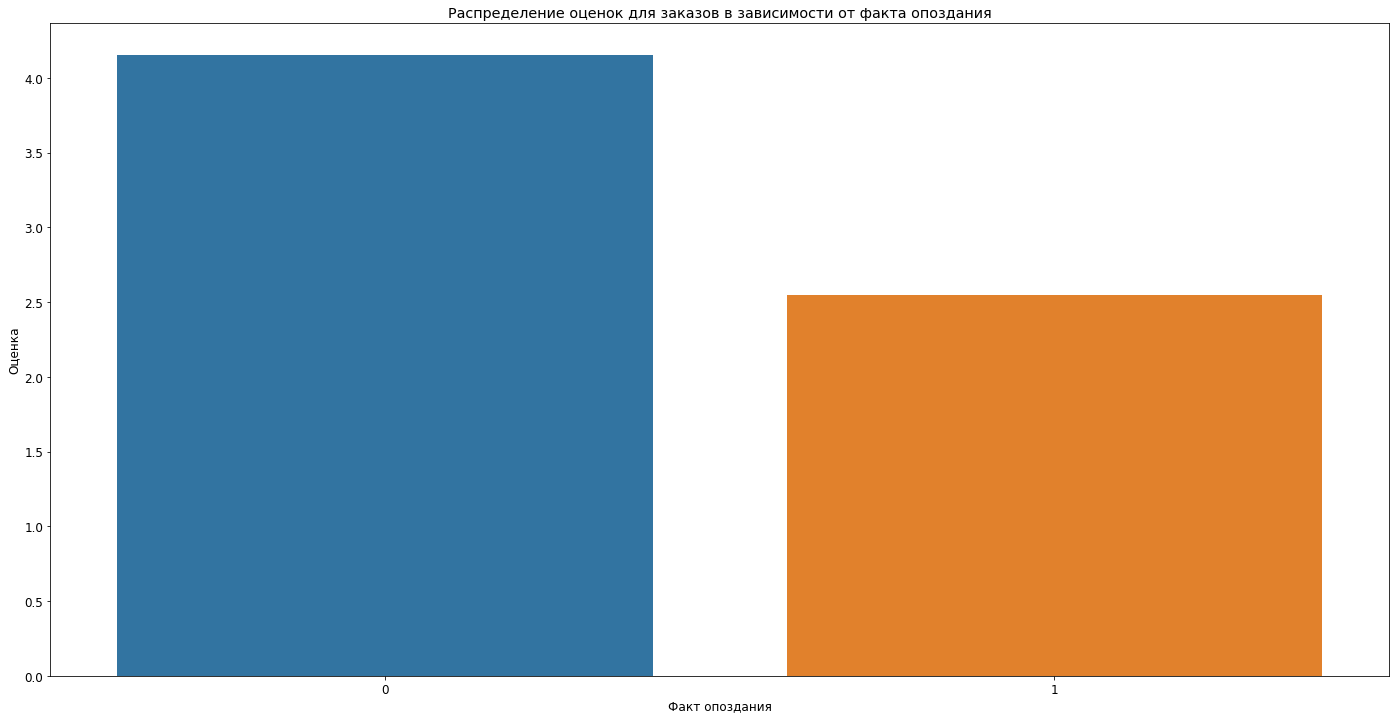

In [48]:
sns.barplot(data = df_islate, x='is_late', y='review_score')
plt.title('Распределение оценок для заказов в зависимости от факта опоздания')
plt.xlabel('Факт опоздания')
plt.ylabel('Оценка')
plt.rcParams['figure.figsize'] = 8, 5
plt.rcParams['font.size'] = 12
plt.show()

## Задание 15*

Есть ли среди пользователей хейтеры? Определите их и вычислите средний CSAT без их участия

Посмотрим на боксплот, чтобы увидеть, кто есть хейтер

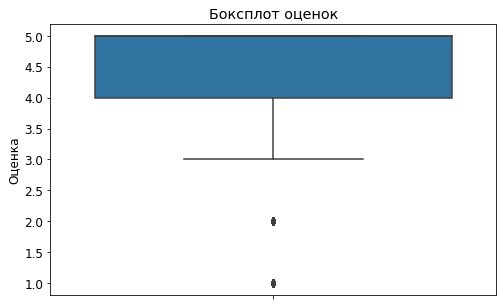

In [49]:
sns.boxplot(y = df['review_score'])

plt.title('Боксплот оценок')
plt.ylabel('Оценка')
plt.rcParams['figure.figsize'] = 8, 5
plt.rcParams['font.size'] = 12
plt.show()

Будем считать хейтером того, у кого средняя оценка отзывов меньше 3

In [50]:
df_haters = df.groupby('customer_id').agg({'review_score': 'mean'}).reset_index()
df_haters = df_haters[df_haters['review_score'] < 3]
df_haters.sample(5)

,customer_id,review_score
11389,1e0f12bffae1cb0f423103ebdb329283,1.0
1846,04d52731fefc328bb6ece40f6cbdd685,1.0
63012,a70cdc7161618ecbfff0bc3de4e09f0b,1.0
74692,c54850e0308f8bdd7d21266938cf544e,1.0
40236,6b170d60eabcac609caaaf419e9e57f1,2.0


In [51]:
print(f"Средний CSAT без учета хейтеров: {np.mean(df[~df['customer_id'].isin(df_haters['customer_id'])]['review_score'])}")

Средний CSAT без учета хейтеров: 4.571761238936229
